# What Influences the SAT Results: Analyzing NYC Schools

In this project, we are going to analyze several data sets in order to understand if the Scholastic Aptitude Test (SAT) is fair to different classes of people (gender/race groups, etc.). The [SAT](https://en.wikipedia.org/wiki/SAT) is a standardized test that every high schools senior takes yearly. It is widely used for college admissions, so it is utterly important to understand what factors influence the its results. Hence we are going to answer the following questions:

* Does safety infuence students' performance?
* How do different ethnic groups perform in the SAT test?
* How do English learners perfom?
* Are they are any gender differences?
* How does the Advanced Placement preparation influence the SAT results?
* Does the average class size influence preparation?

We will combine 7 different data sets freely published by New York City in order to find correlations between SAT scores, different demographic measures (for example, gender/ethnicity) or schools satisfaction scores (for example, school safety):
* [SAT scores by school](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City.
* [School attendance](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt) - Attendance information for each school in New York City.
* [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school.
* [AP test results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam ([Wikipedia](https://en.wikipedia.org/wiki/Advanced_Placement_exams)) results for each high school.
* [Graduation outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a) - The percentage of students who graduated, and other outcome information.
* [Demographics](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j) - Demographic information for each school.
* [School survey](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8) - Surveys of parents, teachers, and students at each school.

## Results
***

After the data analysis, we conclude that the school's safety greatly influences the SAT results and that **the black and Hispanic ethnic groups are highly disadvantaged** because they are attending the less safest schools with poor academic standards. We also observed that the **English learners struggle in achieving high SAT scores**. In addition, we discovered that the Advanced Placement preparation does not influence the SAT scores. Lastly, we observed that schools with bigger classes perform better in the SAT.

**Important notice**: we will be using the 2012 data when the maximum SAT score was 2400 whereas sicne 2016 the maximum score is only 1600.

## Prerequisites 
***

In this project, we will be using five Python packages:
* Numpy
* pandas
* Matplotlib
* Seaborn
* Basemap

## Read in the Data
***

First of all, we will create read in the `csv` datasets and assign them to dictionary keys that have the same names of the datasets to easily access them in the future.

In [1]:
# Import packages
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Display all rows of a dataframe
pd.set_option("display.max_columns", None)

# Display plot in the code block
%matplotlib inline

# .csv files
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv",
]

# Dictionary with .csv datasets
data = {}

for f in data_files:
    d = pd.read_csv("{0}".format(f))
    data[f.replace(".csv", "")] = d

## Read in the Surveys
***

Surveys of teachers, parents and students have `txt` format with tab-separated values in the `windows-1252` enconding, so we have to read them in with some additional parameters. Then we will combine both datasets in one file to ease our analysis.

We will also select only the necessary rows that contain information about the school, response rate, number of respondents and scores for several schools satisfaction measures. The complete information about each field may be found on the [NYC OpenData website](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8) in the file `Survey Data Dictionary.xls`. 

**Important note**: in the dictionary, score names have `10` instead of `11` at the end but the meaning of each field is identical. These numbers may indicate the year when the survey was taken, and the dictionary was not updated.

In [2]:
# Read in surveys and combine them in one file
all_survey = pd.read_csv("survey_all.txt", delimiter="\t", encoding="windows-1252")
d75_survey = pd.read_csv("survey_d75.txt", delimiter="\t", encoding="windows-1252")
survey = pd.concat([all_survey, d75_survey], axis=0)

"""
DBN = District Borough Number, a unique code for each school in NYC
"""

# Rename the dbn columns in DBN to conform it with other datatsets
survey["DBN"] = survey["dbn"]

# Select necessary survey fields
survey_fields = [
    "DBN",
    "rr_s",
    "rr_t",
    "rr_p",
    "N_s",
    "N_t",
    "N_p",
    "saf_p_11",
    "com_p_11",
    "eng_p_11",
    "aca_p_11",
    "saf_t_11",
    "com_t_11",
    "eng_t_11",
    "aca_t_11",
    "saf_s_11",
    "com_s_11",
    "eng_s_11",
    "aca_s_11",
    "saf_tot_11",
    "com_tot_11",
    "eng_tot_11",
    "aca_tot_11",
]
survey = survey.loc[:, survey_fields]
data["survey"] = survey

## Data Cleaning and Combining 
***

Before we analyze our datasets we have to ensure that they contain "tidy" information and combine them to ease the analysis.

Here is what we will have to do:
* Make sure that all datasets have DBN columns because we will eventually combine them by this column.
* Convert all values in numeric type (where possible, of course) to be able to make calculations/plotting.
* Extract coordinates in separate columns in order to map our findings.
* Remove duplicated DBNs to be able to combine the datasets without ambiguity.
* Combine datasets.
* Add a school disctict column to map all schools by district.

### Add/Rename DBN Columns

In the `hs_directory` file, we have to rename `dbn` in `DBN` to conform it with the other datasets.

In [3]:
# Rename dbn columns in surveys and hs_directory
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

In the `class_size` file, there is no DBN column. Let's have a look at the file to see if we can create a DBN number out of available data.

In [4]:
data["class_size"].head(2)

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN


After a quick search on the web, we should find out that a DBN code is made of CSD (City School District), a Borough letter and a School Code. We will have to use only a CSD number and a School Code which already includes a Borough letter. Let's have a look at how DBN codes look like in `sat_results` dataset.

In [5]:
# First five rows
data["sat_results"]["DBN"].head()

0    01M292
1    01M448
2    01M450
3    01M458
4    01M509
Name: DBN, dtype: object

In [6]:
# 35-39 rows
data["sat_results"]["DBN"][35:40]

35    02M419
36    02M420
37    02M425
38    02M427
39    02M429
Name: DBN, dtype: object

In [7]:
# Last five results
data["sat_results"]["DBN"].tail()

473    75X012
474    75X754
475    79M645
476    79Q950
477    79X490
Name: DBN, dtype: object

It is clear that each DBN code starts with a double-digit number, so it is necessesary to make each CSD number double-digit (or to pad a number).

In [8]:
# Function to pad csd
def pad_csd(c):
    return str(c).zfill(2)


# Apply function to CSD column and make a DBN number
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = (
    data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]
)

### Convert Columns to Numeric

The SAT is made up of [three parts](https://en.wikipedia.org/wiki/SAT#Structure):
* Mathematics
* Critical Reading 
* Writing and Language

The `sat_restuls` dataset contains three columns with average scores for each part of the SAT for each school. We will have to convert them into numbers and create a new column with summed scores to ease the correlation analysis (we want them all, right?).

In [9]:
# Convert scores into numbers
cols = [
    "SAT Math Avg. Score",
    "SAT Critical Reading Avg. Score",
    "SAT Writing Avg. Score",
]
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

# Create a column with summed scores
data["sat_results"]["sat_score"] = (
    data["sat_results"][cols[0]]
    + data["sat_results"][cols[1]]
    + data["sat_results"][cols[2]]
)

### Find the Coordinates

We also would like to know the coordinates of each school so we can plot them on the NYC map to see if there is any pattern. The `hs_directory` dataset has what we want: the `Location 1` column has the information about the school address and its coordinates. The coordinates have this format: `(latitude, longitude)`. Great, that is a regular expression! We can extract each coordinate and assign them to new columns. We finally convert each coordinate into numbers.

In [10]:
# Functions to extract latitude and longitude
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat


def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "")
    return lon


# Apply the functions to extract coordinate
data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

# Covnert coordinates into numbers
data["hs_directory"]["lat"] = pd.to_numeric(
    data["hs_directory"]["lat"], errors="coerce"
)
data["hs_directory"]["lon"] = pd.to_numeric(
    data["hs_directory"]["lon"], errors="coerce"
)

### Remove DBN Duplicates

We are almost ready to combine all the datasets but first, we have to condense some of the datasets to have only unique DBN codes and select only the information that is relevant for analysis. We are interested in analyzing the SAT that is taken only by high school seniors. The `class_size` dataset contains information on each class of NYC schools and one of the columns contains information about the grade. Let's have a look at it.

In [11]:
data["class_size"]["GRADE "].unique()

array(['0K', '01', '02', '03', '04', '05', '0K-09', nan, '06', '07', '08',
       'MS Core', '09-12', '09'], dtype=object)

Perfect! Since we are interested only in high school seniors we should select only the `09-12` grade group.

It would also interesting to look at the program type column.

In [12]:
data["class_size"]["PROGRAM TYPE"].value_counts()

GEN ED     14545
CTT         7460
SPEC ED     3653
G&T          469
Name: PROGRAM TYPE, dtype: int64

Apparently the classes have different programs to follow. We will select the `GEN ED` program (*General Education*) type because it is the most frequent group.

Since the `class_size` dataset contains information on each class of various schools it makes sense to suspect that the DBN column has duplicates. Let's check it.

In [13]:
data["class_size"]["DBN"].value_counts()[:5]

15K429    57
09X517    56
09X505    56
15K448    52
21K690    52
Name: DBN, dtype: int64

That's right: we have quite a lot of duplicated DBNs. We will have to group the dataset by the DBN column and calculate the average values for other columns (where appliable, of course, like on `AVERAGE CLASS SIZE`).

In [14]:
# Select only relevant rows
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

# Group the dataset by DBN and calculate mean values
class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

# Check for duplicates
class_size["DBN"].value_counts().head()

21K728    1
10X660    1
11X545    1
13K350    1
21K559    1
Name: DBN, dtype: int64

Now let's have a look at the `demographics` and the `graduation` datasets.

In [15]:
data["demographics"].head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,grade3,grade4,grade5,grade6,grade7,grade8,grade9,grade10,grade11,grade12,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,38,52,29,38,NaN,NaN,NaN,NaN,NaN,NaN,36.0,12.8,57.0,20.3,25,9,10,3.6,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,34,42,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,15.6,55.0,22.6,19,15,18,7.4,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN,261,18,43,39,36,38,47,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,19.9,60.0,23.0,20,14,16,6.1,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,89.4,NaN,252,17,37,44,32,34,39,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.0,19.0,62.0,24.6,21,17,16,6.3,75,29.8,149,59.1,7,2.8,149.0,59.1,103.0,40.9
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,,96.5,208,16,40,28,32,30,24,38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,19.2,46.0,22.1,14,14,16,7.7,67,32.2,118,56.7,6,2.9,124.0,59.6,84.0,40.4


The DBNs are not unique because of the `schoolyear` column that contains information about each school year.

In [16]:
data["demographics"]["schoolyear"].value_counts()

20112012    1509
20102011    1498
20092010    1475
20082009    1441
20072008    1410
20062007    1386
20052006    1356
Name: schoolyear, dtype: int64

We will select only the rows with `20112012` which is the most recent date.

In [17]:
data["demographics"] = data["demographics"][
    data["demographics"]["schoolyear"] == 20112012
]

# Check for duplicates
data["demographics"]["DBN"].value_counts().head()

11X178    1
09X327    1
23K184    1
07X221    1
11X322    1
Name: DBN, dtype: int64

Now we condense the `graduation` dataset. Let's have a look at it.

In [18]:
data["graduation"].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2003,5,s,s,s,s,s,s,s,s,s,s,s,s,s,s,s,s,s,s
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55,37,67.3%,17,30.9%,45.9%,0,0%,0%,17,30.9%,45.9%,20,36.4%,54.1%,15,27.3%,3,5.5%
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64,43,67.2%,27,42.2%,62.8%,0,0%,0%,27,42.2%,62.8%,16,25%,37.200000000000003%,9,14.1%,9,14.1%
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,0,0%,0%,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
4,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006 Aug,78,44,56.4%,37,47.4%,84.1%,0,0%,0%,37,47.4%,84.1%,7,9%,15.9%,15,19.2%,11,14.1%


There are two columns that prevent the DBN code form being unique: `Demographic` and `Cohort`. Since we are interested in the most recent data from full cohort we will select the `Total Cohort` and `2006` rows.

In [19]:
# Select Total cohort and 2006
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][
    data["graduation"]["Demographic"] == "Total Cohort"
]

# Check for duplicates
data["graduation"]["DBN"].value_counts().head()

21K728    1
01M696    1
26Q566    1
02M600    1
18K673    1
Name: DBN, dtype: int64

### Convert AP Columns to Numbers

The only step that remains to accomplish before we combine the datasets is to convert the Advanced Placement numeric columns into actual numbers. AP exams are taken by high school students each May before applying to college to gain credits to facilitate access to a college. AP exams have a 1 to 5 scale and students have to take at least 3 to pass it.

We will have to convert in numbers three columns:
* **AP Test Takers**: number of students who took AP exams.
* **Total Exam Taker**: number of AP exams taken by students.
* **Number of Exams with scores 3 4 or 5**: number of exams passed.

In [20]:
# Select columns
cols = ["AP Test Takers ", "Total Exams Taken", "Number of Exams with scores 3 4 or 5"]

# Convert columns into numeric
for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

### Combine the Datasets

Now we are ready to combine our datasets. It is very important not to lose all the information during the merging process so we have to proceed step by step.

We will combine the datasets by the unique school code (DBN). It is surely possible that several datasets do not have information about some schools (due to human/computer error). For example, some schools may not exist in the `ap_2010` dataset but exist in the `sat_results` dataset and vice versa. 

In the case of the `ap_2010` and `graduation` datasets, the most valuable dataset is `sat_scores` so we will use a `left` join. However, in th case of the `class_size`, `demographics`, `survey` and `hs_directory` datasets we want to preserve the demographic information about each school so we will use an `inner` join.

In [21]:
# Combine sat_results, ap_2010 and graduation datasets
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

In [22]:
# Combine class_size, demographics, survey and hs_directory with combined
to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

Now let's look at the missing values in the combined datasets.

In [23]:
# Null values in combined dataset
combined.isnull().sum()

DBN                                  0
SCHOOL NAME                          0
Num of SAT Test Takers               0
SAT Critical Reading Avg. Score     28
SAT Math Avg. Score                 28
                                  ... 
priority09                         363
priority10                         363
Location 1                           0
lat                                  0
lon                                  0
Length: 159, dtype: int64

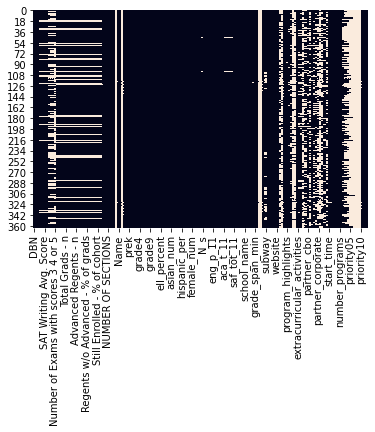

In [24]:
sns.heatmap(combined.isnull(), cbar=False)

There are still quite a lot of missing values in the dataset. We should impute all possible missing values by calculating a mean for those columns or if the imputation is not possible to substitute missing values with zeros (like in some `priority_x` columns).

In [25]:
# Fill missing values
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

### Add School District Column

We will also have to add a school district column to group all schools by district and map them. The school disctict is the first two caracters of its DBN code, hence we will extract them and assign to a new column.

In [26]:
# Extract first two characters of DBN
def get_first_two_chars(dbn):
    return dbn[0:2]

# Create school district column
combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

Now we are ready to start the most interesting part of the project: data analysis!

## Data Analysis
***

After we cleaned and combined the datasets, it is time to start the data analysis! We will have to select what data we want to analyze to answer the questions.

### Finding Correlations

We first look at correlations between the `sat_score` column and any other column to see if there is any negative or positive correlation. In our case, we use the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient). 

In [27]:
correlations = combined.corr()
correlations = correlations["sat_score"]  # Correlations in relation to SAT score
print(correlations[:37])
print(correlations[37:])

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

We observe that:
* There is no surprise that average scores of each part of SAT and SAT scores are correlated between them.
* The percentage of female (`female_per`) and the number of females (`female_num`) correlate positively with SAT scores (but the percentage much less than the number), while the percentage of males (`male_per`) correlates negatively and the number of male (`male_num`) correlate positively. To some extent, correlations of the percentage of each gender may indicate that females score better in the SAT but the correlation is not very strong to make any definitive conclusions.
* The school safety rating of all three survey groups (students (`saf_s_11`), teachers (`saf_t_11`) and parents (`saf_p_11`)) and overall safety have a positive correlation with SAT scores.
* White and Asian ethnic groups (`white_per` and `asian_per`) have a strong positive correlation with SAT scores whilst black and Hispanic groups (`black_per` and `hispanic_per`) have a strong negative correlation with SAT scores. It indicates a pretty big ethnic inequality.
* The percentage of English learners (`ell_perc`) correlates negatively with SAT scores.
* The percentage of students receiving free/reduced lunch (`frl_per`) has a very negative correlation with SAT scores.
* The `total_enrollment` column has a positive correlation with SAT scores. That is surprising because that means that larger schools actually have better SAT results, even though we would have expected that average class size should be bigger so that each student receives less teacher attention.
     * The `total_students`, `N_s`, `N_p`, `N_t`, `AP Exam Takers`, `Total Exams Taken` and `NUMBER OF SECTIONS` columns also correlate positively with SAT scores because they are proxies for the `total_enrollment` column. 

### Plotting Survey Correlations

We will now investigate deeper correlations between SAT scores and survey results of students, parents and teachers to see if there are some strong correlations that catch the attention. To do so, we will create a barplot of each survey and its correlation with SAT score. For a better visualization of distinctive correlation values we a threshold of 0.3.

Text(-1, 0.512, 'Academic and safety satisfaction strongly correlates with SAT results')

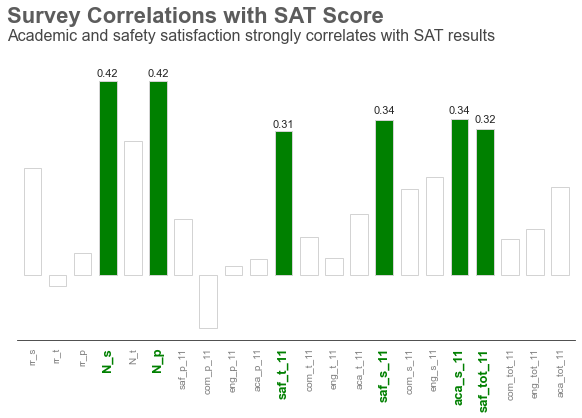

In [28]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

# Font for titles
font_title = {"size": 22, "weight": "bold", "alpha": 0.75}

# Font for subtitles
font_subtitle = {"size": 16, "alpha": 0.85}

# Set plot style
sns.set_style("white")
plt.figure(figsize=(10, 5))

# Plot
ax1 = correlations[survey_fields].plot(
    kind="bar",
    color=np.where(correlations[survey_fields] > 0.3, "green", "white"),
    width=0.7,
    edgecolor="lightgray",
)

# Remove spines
for loc in ["top", "left", "right"]:
    plt.gca().spines[loc].set_visible(False)

# Create labels for correlations > 0.3
labels = [p.get_height() for p in ax1.patches if p.get_height() > 0.3]
labels = [round(x, 2) for x in labels]
pos = list(np.where(correlations[survey_fields] > 0.3)[0])

# Annotate bars with correlations > 0.3
for l, p in zip(labels, pos):
    ax1.text(p, l + 0.012, str(l), ha="center", fontsize=11)

# Remove yticks
plt.yticks([])

# Customize xtick labels
ax1.tick_params(colors="gray")
for p in pos:
    curr_label = ax1.xaxis.get_major_ticks()[p].label
    curr_label.set_fontsize(13)
    curr_label.set_color("green")
    curr_label.set_fontweight("bold")

# Title
plt.text(x=-1, y=0.55, s="Survey Correlations with SAT Score", fontdict=font_title)

# Subtitle
plt.text(
    x=-1,
    y=0.512,
    s="Academic and safety satisfaction strongly correlates with SAT results",
    fontdict=font_subtitle,
)

There some interesting correlations that stick out:
* The number of surveyed students and parents correlate with SAT scores.
* No surprise that academic satisfaction correlates positively with SAT results.
* It is an interesting finding that school safety (`saf_x_11`) correlates positively with SAT scores. We should investigate it further to make sure it is a real correlation!

### Investigating Safety Scores: Safety Means Best Results

Our first question is:
* Does safety infuence students' performance?

To further investigate safety scores we will create a scatter plot to ensure that this measure correlates with SAT results and the correlation coefficient shows an actual correlation between the two measures.

Text(4.5, 2230, 'Beyond safety score of 6.5 there are no high SAT results')

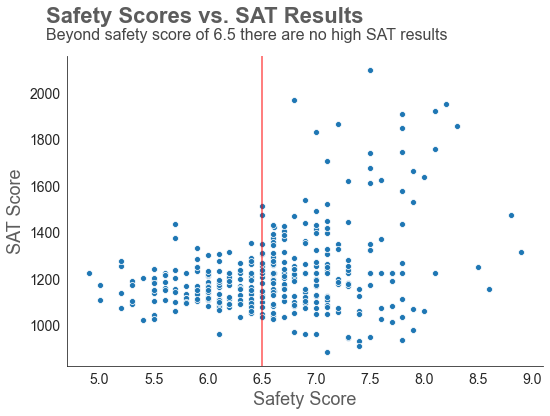

In [29]:
# Seaborn scatter plot for students
sns.relplot(x="saf_s_11", y="sat_score", data=combined, height=5, aspect=1.5)

# Labels
plt.xlabel("Safety Score", fontsize=18, alpha=0.75)
plt.ylabel("SAT Score", fontsize=18, alpha=0.75)

# Tick parameters
plt.tick_params(axis="both", which="major", labelsize=14)

# Vertical x line on 6.5
plt.axvline(x=6.5, c="red", alpha=0.5, linewidth=2)

# Title
plt.text(
    x=4.5, y=2300, s="Safety Scores vs. SAT Results", fontdict=font_title,
)

# Subtitle
plt.text(
    x=4.5,
    y=2230,
    s="Beyond safety score of 6.5 there are no high SAT results",
    fontdict=font_subtitle,
)

We may also group the combined dataset by district, calculate the median for each column and create a scatter plot for students safety scores.

Text(5.75, 1488, 'Beyond safety score of 6.5 there are no high SAT scores')

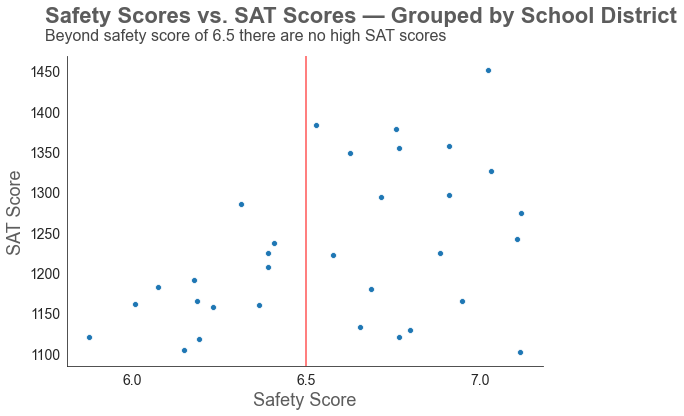

In [30]:
# Combine by district
disctict = combined.groupby("school_dist").agg(np.mean).reset_index()

# Plot
sns.relplot(x="saf_s_11", y="sat_score", data=disctict, height=5, aspect=1.5)

# Labels
plt.xlabel("Safety Score", fontsize=18, alpha=0.75)
plt.ylabel("SAT Score", fontsize=18, alpha=0.75)

# Tick parameters
plt.tick_params(axis="both", which="major", labelsize=14)

# Vertical x line on 6.5
plt.axvline(x=6.5, c="red", alpha=0.5, linewidth=2)

# Reduce number of x ticks
plt.locator_params(axis="x", nbins=3)

# Title
plt.text(
    x=5.75,
    y=1510,
    s="Safety Scores vs. SAT Scores — Grouped by School District",
    fontdict=font_title,
)

# Subtitle
plt.text(
    x=5.75,
    y=1488,
    s="Beyond safety score of 6.5 there are no high SAT scores",
    fontdict=font_subtitle,
)

Our initial findings are confirmed. SAT scores clearly have a positive correlation with safety scores. It may be due to the fact that students who feel safer at school are encouraged to perform better, or it may correlate with academic satisfaction (safer school = better teachers).

### Safety Scores by District: Manhatten is the Best

We now can now map safety scores by district to see if there is any patter in the distribution of safe/not safe schools in NYC. We will use freely available [shapefiles of NYC boroughs](https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm) from the NYC Open Data website.

Text(0, 63000, 'The safest schools are in Manhatten and nearby')

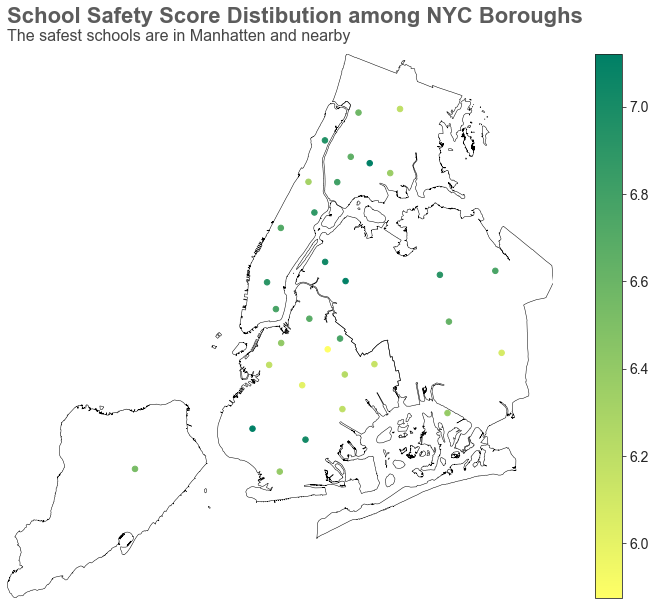

In [31]:
# Plot dimensions
plt.figure(figsize=(15, 10))

# Basemap
m = Basemap(
    projection="merc",
    llcrnrlat=40.496044,
    urcrnrlat=40.915256,
    llcrnrlon=-74.255735,
    urcrnrlon=-73.700272,
    resolution="i",
)

# Shapefile
m.readshapefile("New_York_Boroughs", "New_York_Boroughs")

# Convert coordinates into lists
long = disctict["lon"].tolist()
lat = disctict["lat"].tolist()

# Map of safety scores
m.scatter(
    long, lat, s=30, zorder=2, latlon=True, c=disctict["saf_s_11"], cmap="summer_r"
)

# Remove spines
for loc in ["top", "bottom", "left", "right"]:
    plt.gca().spines[loc].set_visible(False)

# Colorbar
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

# Title
plt.text(
    x=0,
    y=65000,
    s="School Safety Score Distibution among NYC Boroughs",
    fontdict=font_title,
)

# Subtitle
plt.text(
    x=0,
    y=63000,
    s="The safest schools are in Manhatten and nearby",
    fontdict=font_subtitle,
)

There is a clear distribution pattern: the safest schools are located in Manhatten and in the nearby regions of Queens and Bronx. On the other hand, there are only two very safe school districts in Brooklyn.

If we look at the April 2020 crime rates in [this article](https://streeteasy.com/blog/safest-areas-nyc/) it is clear that there is no clear correlation with crime rates and safe schools. Only in the case of Brooklyn the safest schools are located in the safest neighborhoods of the district. For Manhatten the situation is even the opposite: the safest schools are located in the less safest neighbourhoods!

### Safety and Academic Satisfaction: Safer School Means Better Teachers?

Since we said that the safety might be correlated with the academic satisfaction let's also investigate this correlation.

Text(7, 7.3, 'Safety positively influences the academic satisfaction')

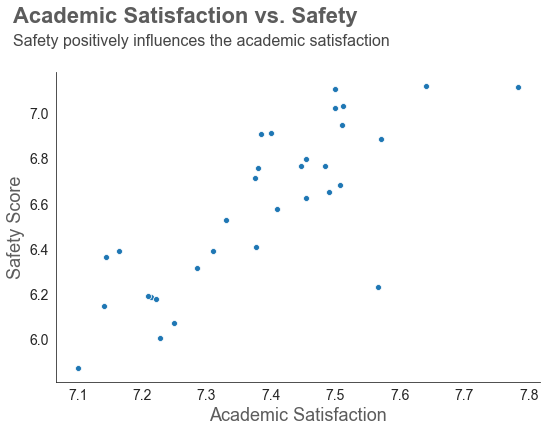

In [32]:
# Plot
sns.relplot(x="aca_s_11", y="saf_s_11", data=disctict, height=5, aspect=1.5)

# Labels
plt.xlabel("Academic Satisfaction", fontsize=18, alpha=0.75)
plt.ylabel("Safety Score", fontsize=18, alpha=0.75)

# Tick parameters
plt.tick_params(axis="both", which="major", labelsize=14)

# Title
plt.text(
    x=7, y=7.4, s="Academic Satisfaction vs. Safety", fontdict=font_title,
)

# Subtitle
plt.text(
    x=7,
    y=7.3,
    s="Safety positively influences the academic satisfaction",
    fontdict=font_subtitle,
)

The safety strongly correlates with the academic satisfaction. It may be an indication that in the safer schools there better teachers that directly influences the SAT results. The most plausible hypothesis is that a combination of both of this factors influence the SAT results but they also influence each other.

### Ethnic Groups and SAT: Blacks and Hispanics Disadvantaged

Our second question is:
* How do different ethnic groups perform in the SAT test?

Let's visualize SAT score correlations with the percentage of ethnic groups (white, black, Asian and Hispanic).

Text(-0.8, 0.74, 'Black and Hispanic groups are strongly disadvantaged')

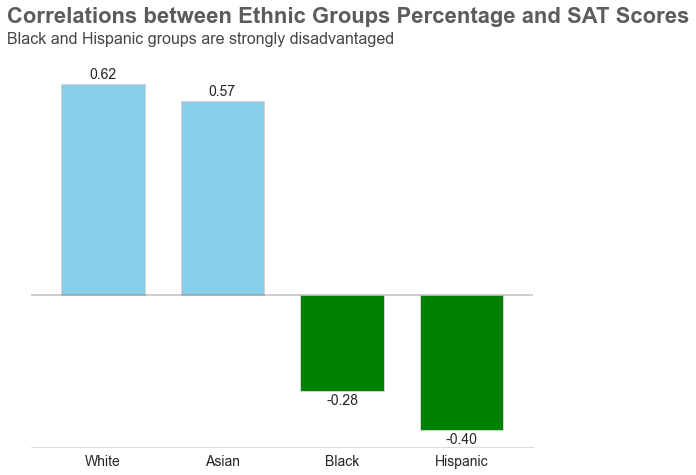

In [33]:
# Ethnic groups percentage
ethnic_groups = ["white_per", "asian_per", "black_per", "hispanic_per"]

# Plot
plt.figure(figsize=(9, 7))
ax2 = correlations[ethnic_groups].plot(
    kind="bar",
    color=np.where(correlations[ethnic_groups] > 0.3, "skyblue", "green"),
    width=0.7,
    edgecolor="lightgray",
    rot=0,
)

# Function to customize bar plot
def data_label(plot):
    for p in plot.patches:
        y = p.get_height()
        x = p.get_x() + p.get_width() / 2

        # Default vertical alignment
        va = "bottom"

        # Default y coordinate of text
        y_text = 2.5

        # Data labels for negative bars
        if y < 0:
            y_text *= -1
            va = "top"

        # Label of bar height
        label = "{:.2f}".format(y)

        # Annotate plot
        plot.annotate(
            label,
            xy=(x, y),
            xytext=(0, y_text),
            textcoords="offset points",
            ha="center",
            va=va,
            fontsize=14,
        )
    # Remove and customize spines
    for loc in ["top", "left", "right"]:
        plot.spines[loc].set_visible(False)
    plot.spines["bottom"].set_alpha(0.2)

    # Remove y ticks
    plot.yaxis.set_ticklabels([])


# Tick parameters
ax2.tick_params(axis="both", which="major", labelsize=14)
ax2.set_xticklabels(labels=["White", "Asian", "Black", "Hispanic"])

# Horizontal line on 0
ax2.axhline(y=0, color="gray", alpha=0.5)

# Data labels
data_label(ax2)

# Title
ax2.text(
    x=-0.8,
    y=0.8,
    s="Correlations between Ethnic Groups Percentage and SAT Scores",
    fontdict=font_title,
)

# Subtitle
ax2.text(
    x=-0.8,
    y=0.74,
    s="Black and Hispanic groups are strongly disadvantaged",
    fontdict=font_subtitle,
)

There is a clear strong difference between black/Hispanic and white/Asian ethnic groups. One possible hypothesis could be that the first group does not study in the best schools as the second group. We may also suppose that the black/Hispanic ethnic groups do not attend the safest schools because there is a strong negative correlation of safety scores with SAT results.

Let's investigate the relation between safety scores and the percentage of black and Hispanic groups.

Text(-5, 9.25, 'The black ethnic group attends less safer schools')

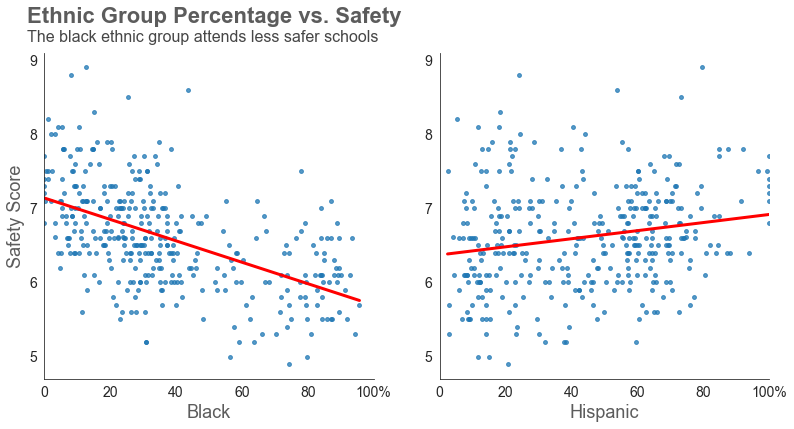

In [34]:
# Black and Hispanic percentage
black_his = ["black_per", "hispanic_per"]

# Scatter and line kwargs
scatter_kws = {"s": 15, "alpha": 0.75}
line_kws = {"color": "red", "lw": 3}

# Correlation scatter plots
fig, ax = plt.subplots(1, 2, figsize=(13, 6))
for group in ["black_per", "hispanic_per"]:
    sns.regplot(
        x=group,
        y="saf_s_11",
        data=combined,
        ax=ax[black_his.index(group)],
        ci=None,
        scatter_kws=scatter_kws,
        line_kws=line_kws,
    )
    ax[black_his.index(group)].set_xlim(0, 100)

# First plot labels
ax[0].set_xlabel("Black", fontsize=18, alpha=0.75)
ax[0].set_ylabel("Safety Score", fontsize=18, alpha=0.75)

# Second plot labels
ax[1].set_xlabel("Hispanic", fontsize=18, alpha=0.75)
ax[1].set_ylabel("")

# Tick parameters
for l in range(0, 2):
    ax[l].tick_params(axis="both", which="major", labelsize=14)
    ax[l].set_xticklabels(labels=[0, "20", "40", "60", "80", "100%"])
    ax[l].locator_params(axis="y", nbins=5)

# Remove top and right spines
for l in ["top", "right"]:
    ax[0].spines[l].set_visible(False)
    ax[1].spines[l].set_visible(False)

# Title and subtitle
ax[0].text(
    x=-5, y=9.5, s="Ethnic Group Percentage vs. Safety", fontdict=font_title,
)

ax[0].text(
    x=-5,
    y=9.25,
    s="The black ethnic group attends less safer schools",
    fontdict=font_subtitle,
)

Only the black ethnic group percentage at schools demonstrates a negative correlation with safety scores, whereas the Hispanic group shows even a very weak positive correlation. 

### Investigating Single Schools

We still have to investigate further our findings: now on the level of single schools.

Let's look at the names of schools that:
* Have more than 90% of the black ethnic group.
* Have more than 95% of the Hispanic ethnic group.
* Have less than 10% of the black or Hispanic ethnic groups and average SAT scores > 1800.

In [35]:
combined[combined["black_per"] > 90][
    ["SCHOOL NAME", "sat_score", "black_per", "saf_s_11", "ell_percent", "school_dist"]
]

,SCHOOL NAME,sat_score,black_per,saf_s_11,ell_percent,school_dist
223,ACADEMY FOR COLLEGE PREPARATION AND CAREER EXP...,1139.0,92.0,5.5,5.0,17
235,MEDGAR EVERS COLLEGE PREPARATORY SCHOOL,1436.0,95.7,5.7,0.0,17
236,CLARA BARTON HIGH SCHOOL,1251.0,91.2,5.9,8.3,17
237,IT TAKES A VILLAGE ACADEMY,963.0,92.9,6.1,30.4,18
241,VICTORY COLLEGIATE HIGH SCHOOL,1143.0,93.5,6.6,5.2,18
331,PATHWAYS COLLEGE PREPARATORY SCHOOL: A COLLEGE...,1173.0,94.2,5.3,2.3,29


What unites the above schools is that students enroll in high school with poor academic skills (except for *Medgar Evers College Preparatory School*). Most of the schools are located in Brooklyn (districts 17 and 18) where most schools have low safety scores. A combination of low safety and poor academic skills may contribute to low average SAT scores. *Medgar Evers College* stands out because despite having the third low safety score it has a relatively high SAT score (1436). All the information was found on [insideschools.org](https://insideschools.org).

Another interesting observation is that *It Takes a Village Academy* has almost 1/3 of students who are English learners. It may also contribute to a very low average SAT score. Now let's look at the Hispanic group.

In [36]:
combined[combined["hispanic_per"] > 95][
    ["SCHOOL NAME", "sat_score", "hispanic_per", "saf_s_11", "ell_percent"]
]

,SCHOOL NAME,sat_score,hispanic_per,saf_s_11,ell_percent
44,MANHATTAN BRIDGES HIGH SCHOOL,1058.0,99.8,7.2,72.6
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,1174.0,96.7,7.5,19.6
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,1014.0,99.8,7.7,89.6
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,951.0,99.4,7.5,86.6
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,934.0,99.8,7.4,79.9
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,970.0,99.8,6.8,92.9
253,MULTICULTURAL HIGH SCHOOL,887.0,99.8,7.1,94.6
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,951.0,100.0,7.3,91.3


After a quick search on insideschools.org, it is clear that all the schools with a high percentage of the Hispanic ethnic group are for immigrants (mostly from Latin America). What also stems out is that most schools have a very high percentage of English learners, even though Washington Heights Expeditionary Learning School does not seem to be exclusively for immigrants (only 19.6% of English learners).

Let's symmetrically look at the schools with low percentage of the black and Hispanic groups and with high average SAT scores. 

In [37]:
combined[
    (combined["black_per"] < 10)
    & (combined["hispanic_per"] < 10)
    & (combined["sat_score"] > 1800)
][["SCHOOL NAME", "sat_score", "hispanic_per", "black_per", "asian_per", "white_per", "saf_s_11", "aca_s_11"]]

,SCHOOL NAME,sat_score,hispanic_per,black_per,asian_per,white_per,saf_s_11,aca_s_11
37,STUYVESANT HIGH SCHOOL,2096.0,2.4,1.2,72.1,23.7,7.5,7.9
151,BRONX HIGH SCHOOL OF SCIENCE,1969.0,7.2,3.5,63.5,25.4,6.8,7.6
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,1953.0,5.3,1.1,31.8,61.3,8.2,8.5


All these schools share very high academic standards, with plenty of extra-curriculum activities and The Bronx High School of Science is one of the most famous  schools in the US so it is straightforward that high SAT scores are due to a great academic preparation. It is unfortunate that they have a very low percentage of the Hispanic and black groups; that indicates that there is still a very high inequality in the US society.

### English Learners and SAT: Clearly Disadvantaged

Our third question is:
* How do English learners perform?

After what we found out analyzing the ethich groups correlations (recall the *It Takes a Village Academy*) it would be interesting to see if the percentage of English learners correlates with SAT scores. We may hypothesize that it is a negative correlation because English learners struggle in understanding the SAT contents.

Text(1900, 80, 'Negative correlation may indicate \nthat English learners $\\mathbf{struggle \\,in}$ \n$\\mathbf{understanding \\, the \\, SAT \\,contents}$')

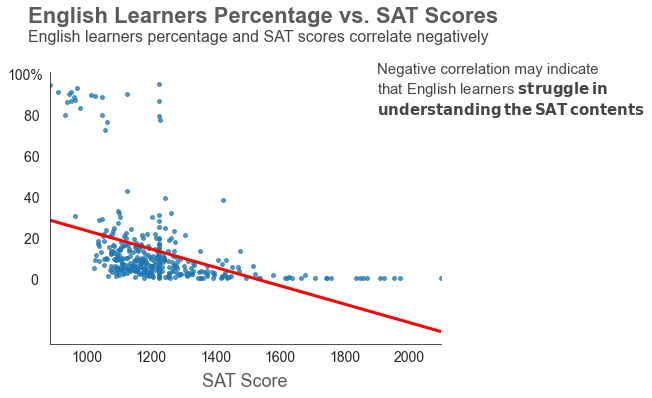

In [38]:
# Correlation scatter plot
plt.figure(figsize=(7, 5))
ax3 = sns.regplot(
    x="sat_score",
    y="ell_percent",
    data=combined,
    ci=None,
    scatter_kws=scatter_kws,
    line_kws=line_kws,
)

# x and y labels
ax3.set_ylabel("")
ax3.set_xlabel("SAT Score", fontsize=18, alpha=0.75)
ax3.xaxis.labelpad = 8

# y tick labels
ax3.set_yticklabels(labels=[-30, "", "0 ", "20 ", "40 ", "60 ", "80 ", "100%"])

# Remove top and right spines
for l in ["top", "right"]:
    ax3.spines[l].set_visible(False)

# Tick parameters
ax3.tick_params(axis="both", which="major", labelsize=14)

# Title and subtitle
ax3.text(
    x=820, y=125, s="English Learners Percentage vs. SAT Scores", fontdict=font_title,
)
ax3.text(
    x=820,
    y=116,
    s="English learners percentage and SAT scores correlate negatively",
    fontdict=font_subtitle,
)

# Comments
ax3.text(
    x=1900,
    y=80,
    s="Negative correlation may indicate \nthat English learners $\mathbf{struggle \,in}$ \n$\mathbf{understanding \, the \, SAT \,contents}$",
    fontdict={"size": 15, "alpha": 0.85},
)

The correlation between English learners percentage and SAT scores is clearly negative. As said previously it may indicate that English learners struggle incomprehending the SAT contents. The educational authorities should pay more attention to the English classes and may allow foreign students to use a bilingual dictionary during the test. Another possible solution could be giving these students more time to finish the test.

### Genders and SAT: Full Equality

Our fourth question is:
* Are they are any gender differences?

It is also interesting and important to see if girls and boys perform differently in the SAT exam. Let's visualize gender correlations with SAT scores.

Text(-1, 0.135, 'Gender Correlations with SAT Scores')

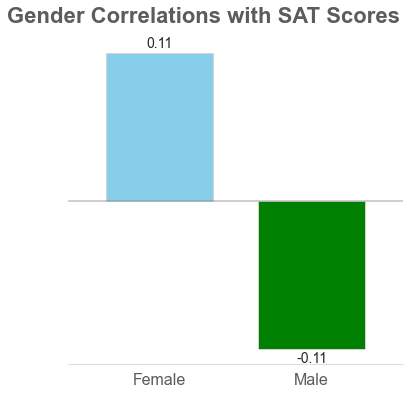

In [39]:
# Gender percentages
genders_per = ["female_per", "male_per"]

# Set plot dimensions
plt.figure(figsize=(6, 6))

# Plot
ax4 = correlations[genders_per].plot(
    kind="bar",
    color=np.where(correlations[genders_per] > 0.1, "skyblue", "green"),
    width=0.7,
    edgecolor="lightgray",
    rot=0,
)

# Data labels
data_label(ax4)

# Tick parameters
ax4.tick_params(axis="x", which="major", pad=5)
ax4.set_xticklabels(labels=["Female", "Male"], alpha=0.75, size=16,)

# Horizontal line on 0
plt.axhline(y=0, color="gray", alpha=0.5)

# Title
plt.text(x=-1, y=0.135, s="Gender Correlations with SAT Scores", fontdict=font_title)

Gender correlations are exactly symmetrical! They are quite weak so we cannot say that females perform better or males perform worse in the SAT exam, so we have to investigate single schools. We will select schools where the female percentage is more than 60% and the average SAT score is more than 1700.

In [40]:
combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)][
    ["SCHOOL NAME", "female_per", "sat_score", "aca_s_11"]
]

,SCHOOL NAME,female_per,sat_score,aca_s_11
5,BARD HIGH SCHOOL EARLY COLLEGE,68.7,1856.0,8.9
26,ELEANOR ROOSEVELT HIGH SCHOOL,67.5,1758.0,8.2
60,BEACON HIGH SCHOOL,61.0,1744.0,8.2
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,73.6,1707.0,7.6
302,TOWNSEND HARRIS HIGH SCHOOL,71.1,1910.0,8.1


After a quick search on insideschools.org, it seems that these schools ask for a very high academic preparation and are almost the best schools in NYC. A higher female percentage might be just a coincidence.

Let's look at the schools with the same parameters but for males.

In [41]:
combined[(combined["male_per"] > 60) & (combined["sat_score"] > 1700)][
    ["SCHOOL NAME", "male_per", "sat_score", "aca_s_11"]
]

,SCHOOL NAME,male_per,sat_score,aca_s_11
79,"HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...",65.8,1847.0,8.2


This high school also has very high academic standards!

We may conclude that there is actually no strong gender correlation with SAT scores. It should be high academic standards that greatly influence average SAT scores.

### Advanced Placement Preparation and SAT: AP Preparation Does Not Mean High SAT Score

Our fifth question is:

* How does the Advanced Placement preparation influence the SAT results?

It is fair to think that the [Advanced Placement](https://en.wikipedia.org/wiki/Advanced_Placement) program with college-level curricula may play a great role in students' preparation for the SAT tests. That means that more students take this program at school higher is the average SAT scores for that school. Let's calculate the percentage of AP takers at each school and create a scatter plot to see if there is any relation with SAT results.

Text(800, 98, 'AP preparation does not mean high SAT score')

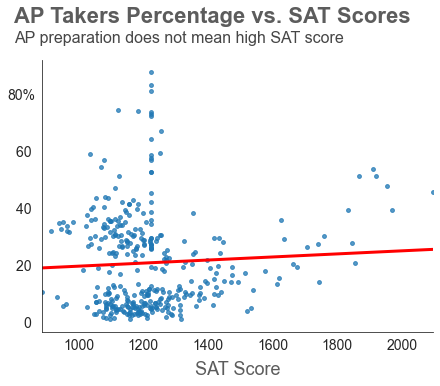

In [42]:
# AP percentage column
combined["ap_percent"] = (
    combined["AP Test Takers "] / combined["total_enrollment"]
) * 100

# Correlation scatter plot
plt.figure(figsize=(7, 5))
ax5 = sns.regplot(
    x="sat_score",
    y="ap_percent",
    data=combined,
    ci=None,
    scatter_kws=scatter_kws,
    line_kws=line_kws,
)

# x and y labels
ax5.set_ylabel("")
ax5.set_xlabel("SAT Score", fontsize=18, alpha=0.75)
ax5.xaxis.labelpad = 8

# y tick labels
ax5.set_yticklabels(labels=[-10, "0 ", "20 ", "40 ", "60 ", "80%"])

# Remove top and right spines
for l in ["top", "right"]:
    ax5.spines[l].set_visible(False)

# Tick parameters
ax5.tick_params(axis="both", which="major", labelsize=14)

# Title and subtitle
ax5.text(
    x=800, y=105, s="AP Takers Percentage vs. SAT Scores", fontdict=font_title,
)

ax5.text(
    x=800,
    y=98,
    s="AP preparation does not mean high SAT score",
    fontdict=font_subtitle,
)

Surprisingly, the Advanced Placement courses do not influence the SAT scores. This may be due to the fact that the AP examination has a lot of different courses and they are now that tight as the SAT tests. For example, a student who prepares the AP Latin and Biology may not be very successful in the SAT reading/mathematics/writing tests.

Still it is important to notice that there are some points in on the right side of the plot where the correlation is positive (after around score 1600) that means that to some extent, the AP preparation influences the SAT results.

### Average Class Size and SAT Scores: Bigger Classes Help

Finally, our last question is:
* Does the average class size influence preparation?

We may suppose that smaller classes receive more teachers' attention so they perform better in the SAT tests. However, was also noticed that bigger schools have better results (and they probably have bigger classes). Let's investigate this relation with a scatterplot (so many of them so far, so useful).

Text(820, 40, 'Bigger classes perfrom better in SAT')

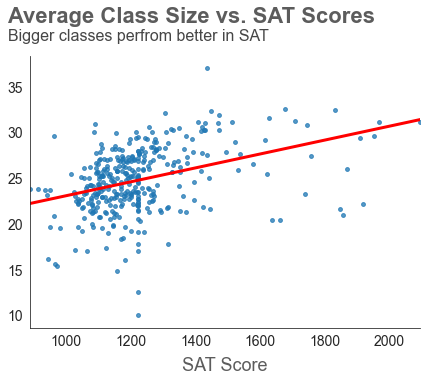

In [43]:
# Correlation scatter plot
plt.figure(figsize=(7, 5))
ax6 = sns.regplot(
    x="sat_score",
    y="AVERAGE CLASS SIZE",
    data=combined,
    ci=None,
    scatter_kws=scatter_kws,
    line_kws=line_kws,
)

# x and y labels
ax6.set_ylabel("")
ax6.set_xlabel("SAT Score", fontsize=18, alpha=0.75)
ax6.xaxis.labelpad = 8

# Remove top and right spines
for l in ["top", "right"]:
    ax6.spines[l].set_visible(False)

# Tick parameters
ax6.tick_params(axis="both", which="major", labelsize=14)

# Title and subtitle
ax6.text(
    x=820, y=42, s="Average Class Size vs. SAT Scores", fontdict=font_title,
)

ax6.text(
    x=820, y=40, s="Bigger classes perfrom better in SAT", fontdict=font_subtitle,
)

It is interesting to observe a moderate positive correlation. That actually means that schools with bigger classes perform better! That could be caused by a better communication between students that promotes a higher exchange of ideas and peer support.

### Conclusions
***

In this project, we have combined and analyzed seven datasets containing information about SAT scores and school demographics in NYC. The aim of the project was to find out what are the factors that influence the student's performance in the SAT test.

We have found out that school **safety greatly influences the average SAT scores** (beyond the score of 6.5 there are no high SAT scores) and it is directly connected the school academic satisfaction of students (we supposed that it means safer schools = better teachers). In addition, we have observed that the safest schools are located in Manhattan and in the nearby regions of Queens and Bronx, and in Brooklyn there only two safe school districts. The school safety though does not always correlate with crime late (for example, in Manhatten the safest schools are located in the neighborhoods with high crime rate). 

Secondly, we observed that the **Hispanic and black ethnic groups are very disadvantaged** in comparison with white and Asian ethnic groups: they study in the less safe schools with poor academic standards. Despite the effort in fighting thnic disequality in the last decades, we are still struggling in providing some ethnic groups with good and safe education. A **disequality is also observed among English learners**: they probably struggle in understanding the SAT contents, therefore are disadvantaged in the test. The educational authorities and teachers should pay more attention to teaching these students the English language and facititate their examination (for example, by allowing them to use a bilingual dictionary).

Thirdly, we discovered that there is no strong evidence in support of gender disequality that is good news after years of fighting for gender equality. There is also (almost) **no evidence that the Advanced Placement preparation influences the SAT scores**. This may be due to the fact that they are very different exams.

Lastly, we found out that **schools with bigger classes perform better in the SAT**. Probably, the idea exchange and greater peer support help students in achieving better results.